<a href="https://colab.research.google.com/github/Timang419/deep-learning-self-study-/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# import the dataset (Cifar10)
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
devtest=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


In [ ]:
len(trainset)

50000

In [ ]:
# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=batchsize) # note: devtest in batches!
test_loader  = DataLoader(testset, batch_size=len(testset))

In [ ]:
# function to compute output size
# w_in ---> numbers of pixels in previous layer
# k    ---> kernel size
#p     ---> padding
#      ---> stride
def compute_output_size(w_in, k, p, s):
    return (w_in + 2*p - k) // s + 1

# design the main Convolutional neural network


In [ ]:
def maketheNet(printtoggle=False):

  class CifarNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      self.print=printtoggle
      ### model architecture

      # convolution layer 1
      self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64)
      # maxpooling need to /2
      output_size1=compute_output_size(32,3,1,1)//2
      # convolution layer 2
      self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(128)
      output_size2=compute_output_size(output_size1,3,1,1)//2
      # convolution layer 3
      self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(256)
      output_size3=compute_output_size(output_size2,3,1,1)//2

      # fully connected layer
      self.fc1=nn.Linear(output_size3*output_size3*256,128)
      # liner layers
      self.fc2=nn.Linear(128,64)
      self.out=nn.Linear(64,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block
      x=F.relu(self.conv1(x))
      x=F.max_pool2d(x,2,2)
      if self.print: print(f'First CPBR block: {list(x.shape)}')

      # second block
      x=F.relu(self.conv2(x))
      x=F.max_pool2d(x,2,2)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block
      x=F.relu(self.conv3(x))
      x=F.max_pool2d(x,2,2)
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # linear layers
      x = x.reshape(x.shape[0], -1)
      if self.print: print(f'Vectorized: {list(x.shape)}')
      # first layer
      x=F.relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      # second linear layer
      x=F.relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training)
      # output layer
      x=self.out(x)
      if self.print: print(f'Final output: {list(x.shape)}')
      return x

  # create the model instance
  net = CifarNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test model with one batch
net,lossfun,optimizer=maketheNet(True)


X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First CPBR block: [32, 64, 16, 16]
Second CPR block: [32, 128, 8, 8]
Third CPR block: [32, 256, 4, 4]
Vectorized: [32, 4096]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3009, grad_fn=<NllLossBackward0>)


Train the network

In [ ]:
# create a function to train the model
def trainTheModel(epoch=10):

  # create the model
  net,lossfun,optimizer=maketheNet()
  net.to(device)

  # initialize the losses
  trainLoss=np.zeros(epoch)
  devLoss=np.zeros(epoch)
  trainAcc=np.zeros(epoch)
  devAcc=np.zeros(epoch)

  ### train loss
  # loop over the epoch to update the training
  for i in range(epoch):

    batchLoss=[]
    batchAcc=[]
    # loop over the batches in the training set
    for X,y in train_loader:

      # move the data to the GPU
      X=X.to(device)
      y=y.to(device)

      # forward pass and loss
      yHat=net(X)
      loss=lossfun(yHat,torch.squeeze(y))

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[i] = np.mean(batchLoss)
    trainAcc[i]  = 100*np.mean(batchAcc)

    ### dev loss (does not affect the model training, is used to fine tune the model if needed)
    # initilize loss and accuracy for each mini bacth
    batchLoss=[]
    batchAcc=[]
    # loop over the batches in the dev set
    for X,y in dev_loader:

      # move the data to the GPU
      X=X.to(device)
      y=y.to(device)

      # forward
      with torch.no_grad():
        yHat=net(X)
        loss=lossfun(yHat,torch.squeeze(y))

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    devLoss[i] = np.mean(batchLoss)
    devAcc[i]  = 100*np.mean(batchAcc)

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net







In [ ]:
trainLoss,devLoss,trainAcc,devAcc,net = trainTheModel(25)

In [ ]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

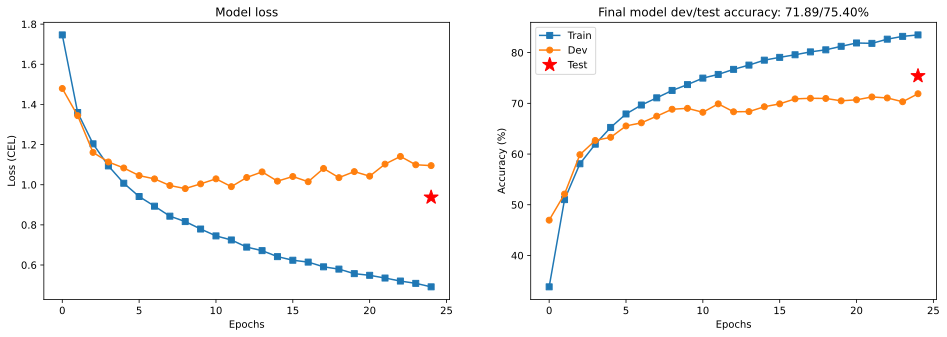

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()